In [5]:
# !git clone https://github.com/benelot/pybullet-gym.git
# !cd pybullet-gym
# !pip install -e .

In [1]:
# Imports
import gym
from gym.wrappers import Monitor
import base64
from pathlib import Path
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import pybullet
import pybulletgym
from tqdm import tqdm
import matplotlib.pyplot as plt
from pickle import load, dump

In [2]:
from enum import Enum
class Environment(Enum): # See https://github.com/benelot/pybullet-gym
    ANT = "AntMuJoCoEnv-v0"
    CHEETAH = "HalfCheetahMuJoCoEnv-v0"
    HOPPER = "HopperMuJoCoEnv-v0"
    #SWIMMER = "Swimmer-v2" # Not yet available in pybullet
    WALKER = "Walker2DMuJoCoEnv-v0"
    HUMAN = "HumanoidMuJoCoEnv-v0"

class Direction(Enum):
    POSITIVE = 1
    NEGATIVE = -1
    BEST = 0

In [ ]:
# Code is inspired from https://github.com/ashutoshtiwari13/Simple-Random-Search/blob/d63efb4863453d354088e1e48cc6cabb26289cef/ars.py

In [ ]:
# class BRS():
#     """Basic Random Search"""
#     def __init__(self, step_size: float, N: int, std_exp_noise: float) -> None:
#         self.step_size = step_size
#         self.N = N
#         self.std_exp_noise = std_exp_noise
    
    
#     def run_episode(self, env:gym.Env, policy: Policy, direction, delta):
#         state = env.reset()
#         done = False
#         total_reward = 0
#         while not done:
#             action = policy.evaluate(state, direction, self.std_exp_noise, delta)
#             state, reward, done, _  = env.step(action)
#             reward = max(min(reward, 1), -1)
#             total_reward += reward
        
#         return total_reward


#     def execute(self, env: gym.Env, n_steps, policy = None, render=False):
#         if render:
#             env = Monitor(env, "./outputs", force=True)
#         if policy is None:
#             policy = Policy(env)
        
#         rewards = []
#         for _ in tqdm(range(n_steps)):
#             deltas = policy.sample_deltas(self.N)
#             positive_rewards = np.array([self.run_episode(env, policy, Direction.POSITIVE.value, delta) for delta in deltas])
#             negative_rewards = np.array([self.run_episode(env, policy, Direction.NEGATIVE.value, delta) for delta in deltas])

#             policy.update(self.step_size, positive_rewards, negative_rewards, self.N, deltas)
#             rewards.append(self.run_episode(env, policy, Direction.BEST.value, 0))
        
#         return policy, rewards

In [3]:
class Policy():
    def __init__(self, env: gym.Env) -> None:
        self.theta = np.zeros((env.action_space.shape[0], env.observation_space.shape[0]))
    
    def evaluate(self, state, direction: int, std_exp_noise: float, delta: float):
        return (self.theta + direction * std_exp_noise * delta).dot(state.reshape(-1,1))
    
    def sample_deltas(self, n_directions):
        return np.array([np.random.randn(*self.theta.shape) for _ in range(n_directions)])
    
    def update(self, step_size, pos_rewards, neg_rewards, n_best_directions, deltas):
        std_rewards = np.array(pos_rewards + neg_rewards).std()
        self.theta += step_size / (n_best_directions * std_rewards) * np.sum((pos_rewards - neg_rewards).reshape(-1,1,1) * deltas, axis=0)

In [4]:
class BaseNormalizer():

    def observe(self, x):
        pass

    def normalize(self, inputs):
        return inputs

class Normalizer(BaseNormalizer):

    def init(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min=1e-2)

    def normalize(self, inputs):
        self.observe(inputs)
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [5]:
class ARS():
    """Augmented Random Search"""
    def __init__(self, env: gym.Env, step_size: float, n_directions: int, std_exp_noise: float, n_best_directions: int, is_V2=False, output_path="./outputs") -> None:
        assert n_best_directions <= n_directions
        self.step_size = step_size
        self.n_directions = n_directions
        self.n_best_directions = n_best_directions
        self.std_exp_noise = std_exp_noise
        self.env = env
        self.eval_env = Monitor(env, output_path, force=True)
        if is_V2:
            self.normalizer = Normalizer(env.observation_space.shape[0])
        else:
            self.normalizer = BaseNormalizer()

        
    
    
    def run_episode(self, policy: Policy, direction: Direction = Direction.BEST.value, delta=0, render=False):
        temp_env = self.env
        if render:
            temp_env = self.eval_env
        state = temp_env.reset()
        done = False
        total_reward = 0
        while not done:
            state = self.normalizer.normalize(state)
            action = policy.evaluate(state, direction, self.std_exp_noise, delta)
            state, reward, done, _  = temp_env.step(action)
            reward = max(min(reward, 1), -1)
            total_reward += reward
        
        return total_reward

    def execute(self, n_steps, policy = None, render=False):
        if policy is None:
            policy = Policy(self.env)
        
        rewards = []
        for i in tqdm(range(n_steps)):
            deltas = policy.sample_deltas(self.n_directions)
            positive_rewards = np.array([self.run_episode(policy, Direction.POSITIVE.value, delta) for delta in deltas])
            negative_rewards = np.array([self.run_episode(policy, Direction.NEGATIVE.value, delta) for delta in deltas])

            scores = {k: max(r_pos, r_neg) for k, (r_pos, r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)[:self.n_best_directions]
            positive_rewards = np.array([positive_rewards[k] for k in order])
            negative_rewards = np.array([negative_rewards[k] for k in order])
            deltas = np.array([deltas[k] for k in order])

            policy.update(self.step_size, positive_rewards, negative_rewards, self.n_best_directions, deltas)
            reward = self.run_episode(policy, render=render)
            if render and i % 100 == 0:
                print(f"Step {i}: {reward}")
            rewards.append(reward)
        
        return policy, rewards


In [6]:
from dataclasses import dataclass

@dataclass
class HyperParameters:
    nb_steps: int = 1000
    learning_rate: float = 0.01
    nb_directions: int = 8
    std_exp_noise: float = 0.025
    nb_best_directions:int = 4
    max_episode_length = 1000
    seed: int = 8953

In [9]:

hp = HyperParameters()
env = gym.make(Environment.HOPPER.value)
ars = ARS(env, hp.learning_rate, hp.nb_directions, hp.std_exp_noise, hp.nb_best_directions)
policy, rewards = ars.execute(hp.nb_steps, render=True)



WalkerBase::__init__


  1%|          | 1/100 [00:00<00:41,  2.39it/s]

Step 0: 3.137914945884379


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


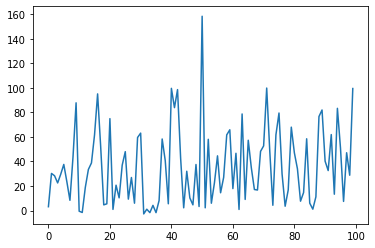

In [10]:
plt.plot(rewards)

In [ ]:
@dataclass
class ARSOutput():
    policy: Policy
    rewards: list
    hyper_parameters: HyperParameters
    env: str

In [ ]:
def save_output(path:str, policy: Policy, rewards: list, hp: HyperParameters, env: str):
    output = ARSOutput(policy, rewards, hp, env)
    with open(path, "wb") as f:
        dump(output, f)

def load_output(path:str)-> ARSOutput:
    with open(path, "rb") as f:
        return load(f)
    